# Explorative Data Analysis - Simonato
In this notebook we will import the dataset from [Kaggle - Zillow Prize](https://www.kaggle.com/c/zillow-prize-1/data) and prepare it for prediction!

## Problem definition

How can we assess the value of a house, or better, the **sale price**? 

In this case we don't have the sale price (for privacy reasons we suppose), but we have the logerror:

$logerror = \log(Zestimate)-\log(SalePrice)$

This is a measure that we can use for our purpose.

Now, it is easier to understand what our real goal is: **predicting a number through regression**. 

### Understand the context: housing-market in the west coast of the U.S.A.
Other than finding links between features, we need to point out some factors we cannot easily include when making our predictions.

We are given a "full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016 and 2017", What problems are we facing now?

1. We are focusing on a particular geographical area, which we are not familiar with;
2. We are focusing on a market we have no prior domain-knowledge of.

Therefore, we have not a clue of how the market is going for houses there, nor we know what gets a house to a particular sale price (the weight of each feature). While the first can be hardly tracked,
we can find out about the latter two through data exploration and domain research.

As we know, datasets rarely are perfect, so we must perform some adjustments to make it usable with our
regression algorithms and find out useful information!


### Need for a clean & clear dataset

The following approach allows us to use a vast variety of cleaning and feature engineering strategies to converge to a perfect training dataset.

1. Basic Exploration
2. Data Cleaning & Feature Engineering
3. Modeling
4. Export

However, we will not follow a linear approach. We will improve the quality of the dataset as soon as we have the chance and we will try to keep up with all the dependencies between the data.

## Step 1: Basic Exploration
First of all, we need to import our data and set up our environment

In this step, we define the sources of data, define data schemas
and tables, understand the main characteristics of the data.

The golden rule here is not to touch the dataset!

### Importing all the dependencies (just in case)

In [1]:
dependencies = ['pandas', 'numpy', 'missingno', 'seaborn', 'folium', 'sklearn', 'matplotlib', 'datetime','xgboost', 'lightgbm']
for i in dependencies:
    !pip install {i}

### Environment & Global Imports

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import folium
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
from math import floor, ceil, log10

color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.style.use('ggplot')
%matplotlib inline
# It's important to set it up before anything

### Data Loading
Loading the data and joining the properties dataset with the train dataset.

In [3]:
# DataFrame downloaded and splitted into properties and train for 2016 and 2017 

def load_merge_proptrain(dataset1, dataset2, predicate):
    properties = pd.read_csv(dataset1, low_memory = True)
    train = pd.read_csv(dataset2, low_memory = True)
    # Let's merge the respective years 
    merged = pd.merge(properties, train, how = 'inner', on = predicate)
    return merged


data2016 = load_merge_proptrain("Data/properties_2016.csv", "Data/train_2016_v2.csv", 'parcelid')

C:\Users\nsimo\AppData\Local\Temp\ipykernel_6204\3820226437.py:4: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv(dataset1, low_memory = True)


Now, we have two choices
* Merge them together
    * Can complicate the learning process
* Use the 2017 data to test our cleaning and feature engineering process
    * We will still perform the same computations on both datasets
    
We'll keep them separated for now.

In [4]:
# Shape
print(f'Shape of data2016 is:\t {data2016.shape}')

Shape of data2016 is:	 (90275, 60)


### Step 1.1 Basic Info

Let's find out some basic information about out dataset, such as:
* Memory usage
* Total count of entries (rows)
* What features are present (columns)

In [5]:
#Print avoiding Notebook Flood
print('2016 House Dataset')
print('============================================================')
data2016.info(verbose=False)


print('\n\n2016 House Dataset Shape')
print('============================================================')
print(data2016.shape)


2016 House Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Columns: 60 entries, parcelid to transactiondate
dtypes: float64(53), int64(1), object(6)
memory usage: 42.0+ MB


2016 House Dataset Shape
(90275, 60)


In [6]:
data2016.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,9.027500e+04,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,658.0,6856.000000,89614.000000,85596.000000,33.000000,3564.000000,6856.000000,421.000000,90275.000000,9607.000000,89093.000000,29937.000000,29937.000000,56080.000000,9.027500e+04,9.027500e+04,8.012500e+04,17901.0,969.000000,1161.0,1204.0,16697.0,90275.000000,9.027500e+04,88472.000000,90275.000000,36012.000000,90240.000000,90275.000000,43.0,12009.000000,299.000000,58353.000000,2646.000000,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04,90275.000000
mean,1.298466e+07,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,66.0,1347.974037,1773.185987,1745.454531,1404.545455,2380.090067,1355.546674,2302.546318,6048.870551,1.187884,2.241231,1.812005,345.521228,3.926979,3.400541e+07,-1.181989e+08,2.911016e+04,1.0,519.827657,1.0,1.0,1.0,261.832179,6.049179e+07,33761.332851,2525.420770,190646.540237,96586.131184,1.478516,7.0,1.008743,6.010033,1.110414,310.142101,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13,0.011457
std,2.504510e+06,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,0.0,652.399026,928.162393,909.941166,110.108211,1068.207182,673.703488,1346.255242,20.663461,0.484173,0.963142,0.608761,267.015918,3.684382,2.649654e+05,3.606032e+05,1.217213e+05,0.0,155.054210,0.0,0.0,0.0,5.182901,2.050549e+05,46672.393863,805.694842,166228.910572,3661.339094,2.819627,0.0,0.100830,0.437235,0.797235,216.721869,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11,0.161079
min,1.071174e+07,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,44.000000,2.000000,2.000000,1056.000000,560.000000,44.000000,257.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,1.0,28.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,25.000000,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13,-4.605000
25%,1.155950e+07,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,66.0,938.000000,1184.000000,1172.000000,1392.000000,1648.000000,938.000000,1112.000000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.381154e+07,-1.184117e+08,5.703000e+03,1.0,420.000000,1.0,1.0,1.0,261.000000,6.037320e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,180.000000,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13,-0.025300
50%,1.254734e+07,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,66.0,1244.000000,1540.000000,1518.000000,1440.000000,2104.500000,1248.000000,2028.000000,6037.000000,1.000000,2.000000,2.000000,433.000000,2.000000,3.402150e+07,-1.181734e+08,7.200000e+03,1.0,500.000000,1.0,1.0,1.0,261.000000,6.037620e+07,25218.0

### Step 1.2 Check data types & Study Categorical Features

We have found out that *float64(53), int64(1), object(6)*

Let's analyze the 6 objects first.

In [7]:
data2016.select_dtypes(include = 'object').columns

Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag', 'transactiondate'],
      dtype='object')

##### Step 1.2.1 Categorical  features

Quick fixes that we can take into account are:
* Convert `transactiondate` into a format that is better fit
* Encode `hashottuborspa`, `fireplaceflag`
    * Add new feature `hashottub`, a number either 0 or 1
    * Add new feature `hasspa`, a number either 0 or 1
    * Add new feature `hasfireplace`, a number either 0 or 1
    * remove `hashottuborspa`
* Consider using the different labels of `propertyzoningdesc` for prediction
    * Might fill the missing values with KNN
* `taxdelinquencyflag`, `propertycountylandusecode`, `propertyzoningdesc` could be helpful but we still need to see their missing values rates

We will make these adjustments later.

##### Step 1.2.2 Numerical features

While for the numerical features, we can consider these options:
* Convert all the float64 to float32, for faster computation.
    * To avoid losing information we can rescale the data and then convert it all, so the change will be uniform.
* Convert int64 to float32, if it makes sense
    * Remember we cannot say there is 1.5 pools in a house!

### Step 1.3 Correlation

Before taking any decision we have to study the correlations and the missing values rate.

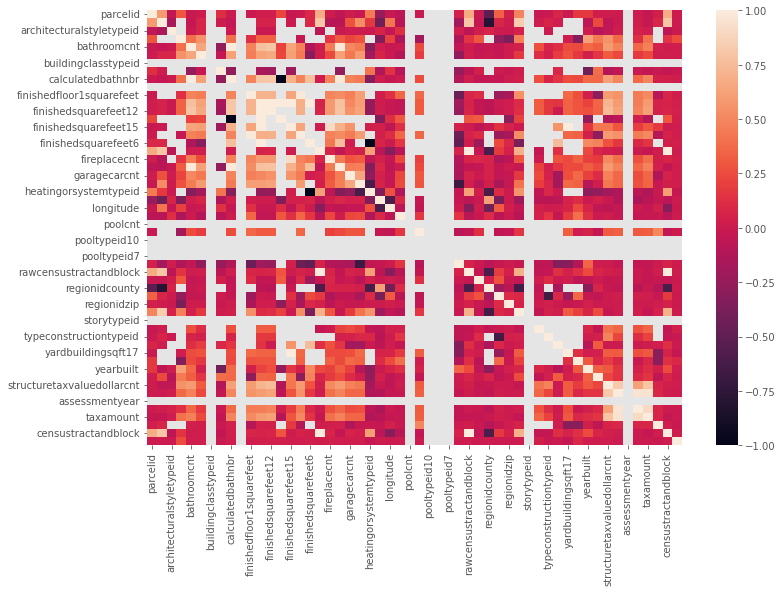

<Figure size 432x288 with 0 Axes>

In [8]:
def numeric_heatmap(df, col_type):
    plt.figure(figsize = (12,8))
    sns.heatmap(data=df.select_dtypes(include=col_type).corr())
    plt.show()
    plt.gcf().clear()
    pass

cols = ['float64','int64'] #choose the type you want to see
numeric_heatmap(data2016, cols)

It doesn't look like there are some significant patterns, so we can skip this step.

### Step 1.4:  Identify Missing Values

Here, we identify feature with more than 89% missing values.
* If they are categorical, we need to carefully study them
* If they are numerical, it feels more reasonable to drop them. Or else they will be in the way of the estimation.

Let's start by visualizing those features and then drop some of them.

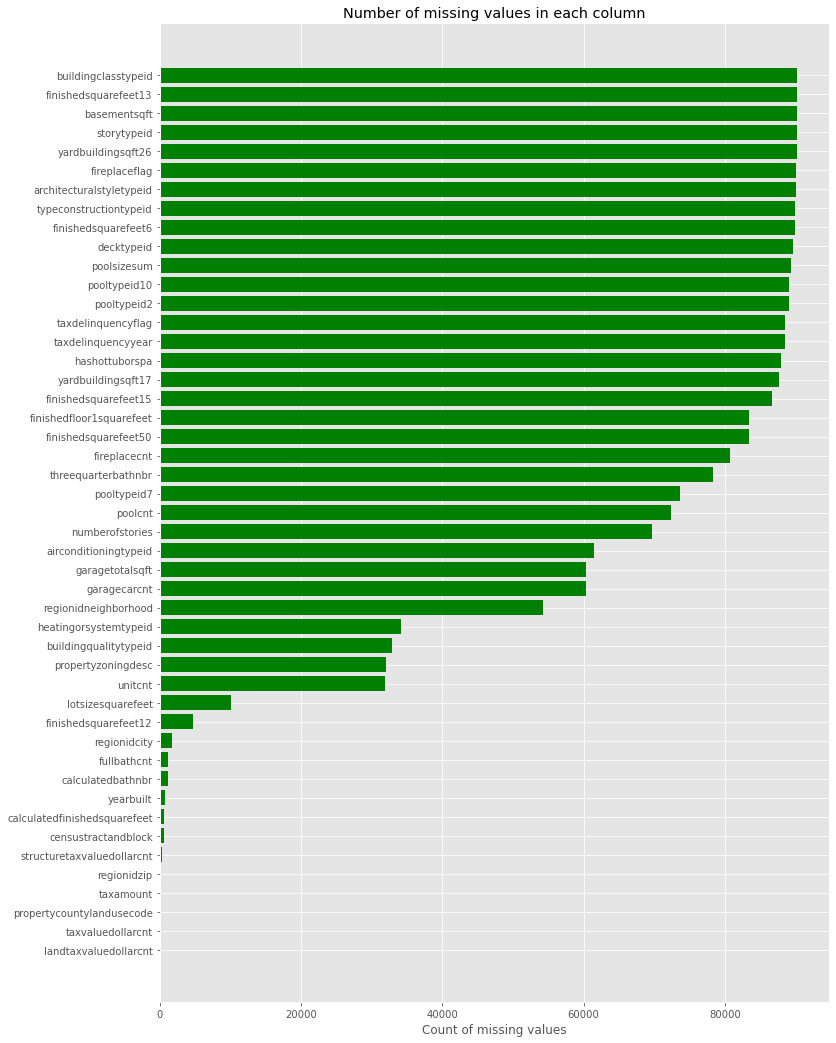

In [9]:
def missing_values_barplot(dataset, percentage=False):
    missing_df = dataset.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    if(percentage):
        # missing_df = missing_df.loc[missing_df['missing_count']>0] * 100 / missing_df
        missing_df = missing_df.div(missing_df.sum(axis=1), axis=0).multiply(100)
    else:
        missing_df = missing_df.loc[missing_df['missing_count']>0]
    
    missing_df = missing_df.sort_values(by='missing_count')

    ind = np.arange(missing_df.shape[0])
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,18))
    rects = ax.barh(ind, missing_df.missing_count.values, color='green')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()
    pass

missing_values_barplot(data2016)

In [10]:
missing_ratio = data2016.isna().sum().sort_values(ascending = False)/len(data2016)
missing_ratio

buildingclasstypeid             0.999823
finishedsquarefeet13            0.999634
basementsqft                    0.999524
storytypeid                     0.999524
yardbuildingsqft26              0.998948
fireplaceflag                   0.997541
architecturalstyletypeid        0.997109
typeconstructiontypeid          0.996688
finishedsquarefeet6             0.995336
decktypeid                      0.992711
poolsizesum                     0.989266
pooltypeid10                    0.987139
pooltypeid2                     0.986663
taxdelinquencyyear              0.980249
taxdelinquencyflag              0.980249
hashottuborspa                  0.973802
yardbuildingsqft17              0.970690
finishedsquarefeet15            0.960521
finishedsquarefeet50            0.924054
finishedfloor1squarefeet        0.924054
fireplacecnt                    0.893581
threequarterbathnbr             0.866973
pooltypeid7                     0.815043
poolcnt                         0.801706
numberofstories 

We understand now that we have three kinds of problems here:
* Missing more than 89%
    * Probably best to drop, unless they are categorical
* Missing more than 60%
    * Could be time for some feature engineering 
    * Can be filled artificially
* Missing 10% or less
    * Can be filled artificially

The first thing to is to drop some data, which might be in our way to predict the logerror. Too many feature become difficult to handle.

##### Step 1.4.1 Removing features that miss 89% of data or more

In [11]:
to_drop = missing_ratio[missing_ratio>=0.89].index.tolist()
data2016[to_drop].dtypes

buildingclasstypeid         float64
finishedsquarefeet13        float64
basementsqft                float64
storytypeid                 float64
yardbuildingsqft26          float64
fireplaceflag                object
architecturalstyletypeid    float64
typeconstructiontypeid      float64
finishedsquarefeet6         float64
decktypeid                  float64
poolsizesum                 float64
pooltypeid10                float64
pooltypeid2                 float64
taxdelinquencyyear          float64
taxdelinquencyflag           object
hashottuborspa               object
yardbuildingsqft17          float64
finishedsquarefeet15        float64
finishedsquarefeet50        float64
finishedfloor1squarefeet    float64
fireplacecnt                float64
dtype: object

We will follow the strategy as stated before for every object present here, apart from `taxdelinquencyflag` which may needs to be encoded.

NA values in each variable means that there is no fireplace/hot tub(spa) and property taxes for this parcel are not past due as of 2015. That is, NA is **unique category** in those variables.

Just to be sure, let's plot a heat map to see if there is a pattern we can exploit!

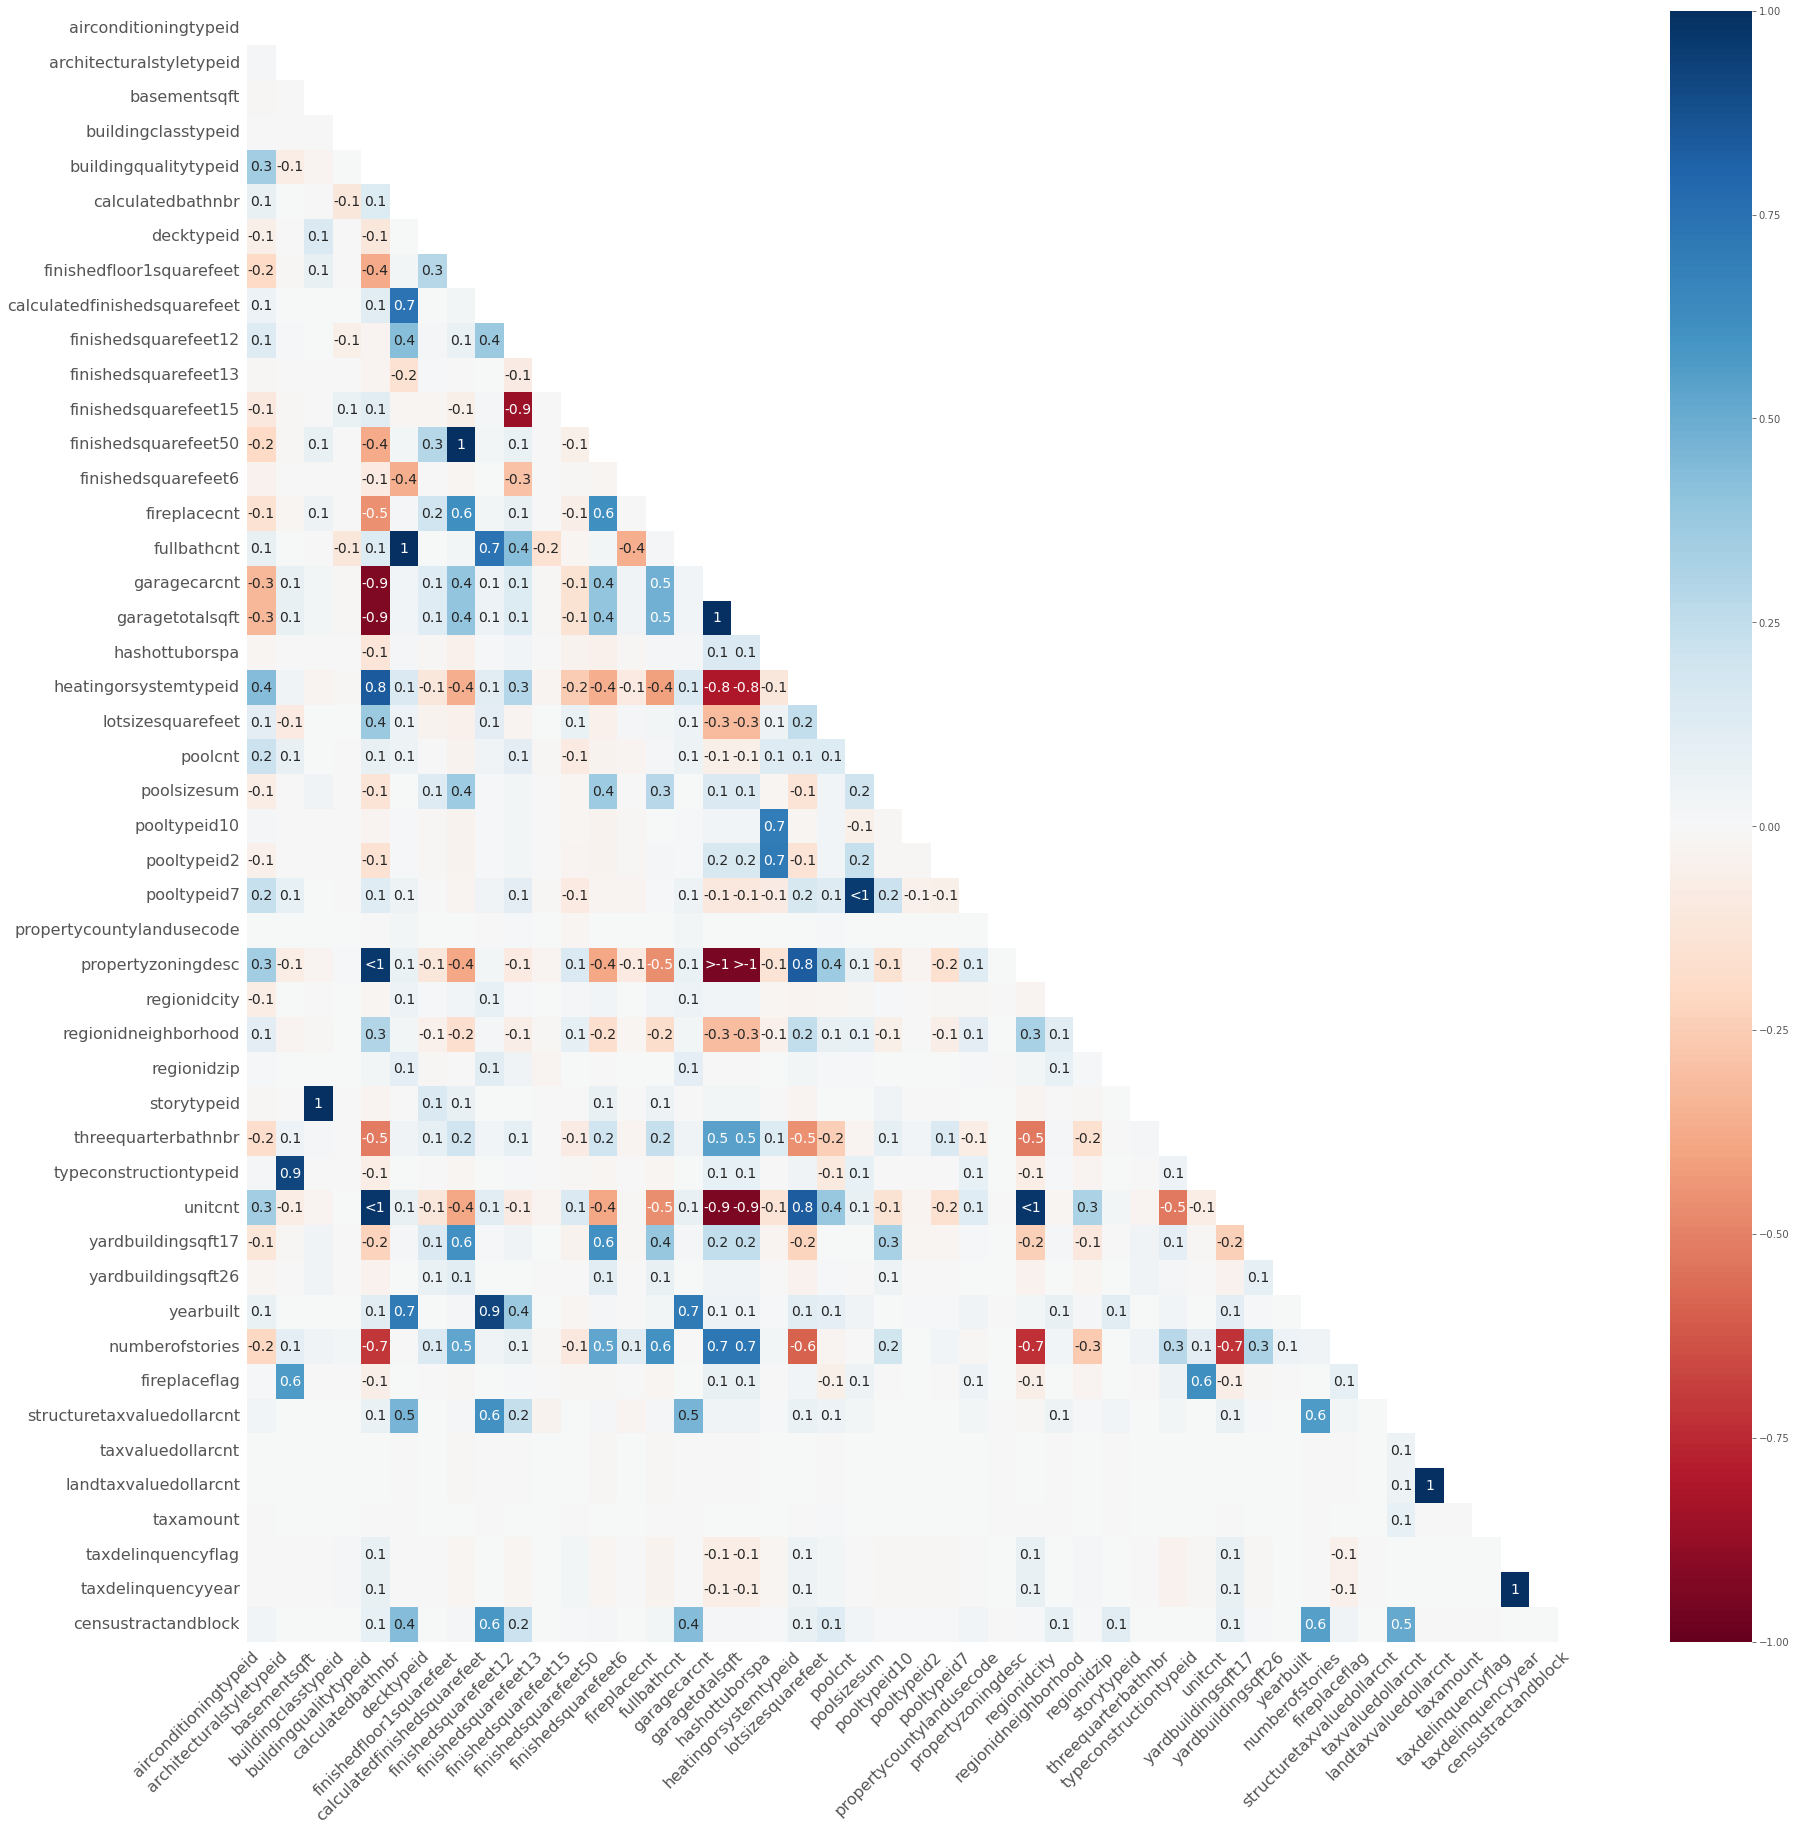

In [12]:
def missing_values_heatmap(dataset):
    missingValueColumns = dataset.columns[dataset.isnull().any()].tolist()
    msno.heatmap(dataset[missingValueColumns],figsize=(30,30))
    pass

missing_values_heatmap(data2016)

We can see that some feature that are correlated, also are very redundant!

By looking at the claims description they represent very similair pieces of information (the area of the property) lets pick the one with the fewest number of missing values and drop the rest. 

### Step 1.5: LogError Outliers
This step's goal is to identify the presence of eventual outliers and to evaluate the appropriate way to handle them.

The first thing we are going to do is to plot the LogError distribution over the recorded values.

The second thing we are going to do is to plot the frequency of the LogError's values over the recorder values.

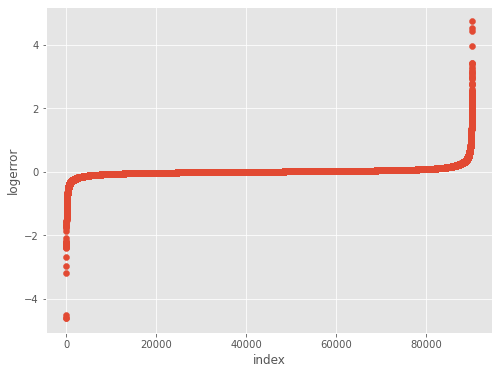

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(range(data2016.shape[0]), np.sort(data2016.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

We can say that most of the values of the LogError belong to the interval $[-2,2]$. 

This could be an hint on where to draw the line between normal values and outliers.

Let's visualize the frequency distribution.

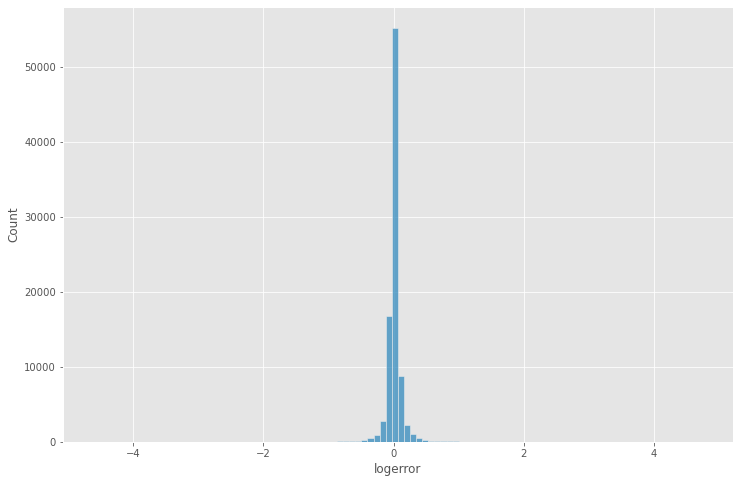

In [14]:
plt.figure(figsize=(12,8))
sns.histplot(data2016.logerror.values, bins=100, kde=False)
plt.xlabel('logerror', fontsize=12)
# plt.xlim((-4,4))
plt.show()

It is obvious that most of the values belongs to the interval $[-1,1]$.

But, even if it's hard to see it, there are some values that lie in the intervals $[-4,-1]$ and $[1,4]$.

Let's evaluate the entity of the presence of the outliers that belongs in these two intervals. The value will be computed from different increasing spans.

In [15]:
for i in [0.5,1.0,1.5,2.0,2.5,3.0,3.5]:
    print(f"Percentage of outliers, assuming as the regular values interval [-{i},{i}] : {100*(data2016[data2016['logerror'] > i].size + data2016[data2016['logerror'] < -i].size) / data2016.size} %")

Percentage of outliers, assuming as the regular values interval [-0.5,0.5] : 1.3890888950429243 %
Percentage of outliers, assuming as the regular values interval [-1.0,1.0] : 0.3788424259207976 %
Percentage of outliers, assuming as the regular values interval [-1.5,1.5] : 0.1772362226530047 %
Percentage of outliers, assuming as the regular values interval [-2.0,2.0] : 0.12517308224868456 %
Percentage of outliers, assuming as the regular values interval [-2.5,2.5] : 0.03544724453060094 %
Percentage of outliers, assuming as the regular values interval [-3.0,3.0] : 0.01993907504846303 %
Percentage of outliers, assuming as the regular values interval [-3.5,3.5] : 0.007754084741068956 %


It's clear that the more we widen the interval of regular values, the less they are relevant.

We also need to consider that the LogError measure involves the use of the logarithm, so the presence of these values is not necessarily correlated to a problem of any kind. Even if we consider the presence of this values, the distribution curve appears to be nicely normal. Therefore, for the moment, no action will be taken.

## Step 2: Cleaning and Feature Engineering
#### A feature problem

Some of these columns are not useful for our purpose, this is why after an extensive research we understood the main driving factors for house prices:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market and economic change
8. Mortgage interest rate

----

However, we do not have data for each one of those points and most of them are hard to represent in the way the datasets are given to us (even if wanted to add some features of our own).

We have to face some difficult decisions now, which will mainly concern:
* Type Conversion
* Rescaling
* Dropping Values
    * Outliers
    * Empty Columns
* Artificial Filling (if over 60%)

In [16]:
#Binding the dataset to a new name
df_train = data2016

### Step 2.1: Data Cleaning
We need to identify
- Missing data
- Unhelpful features
- Non-numeric data
- Data that needs to be rescaled 

---

In section 1.4 we identified the columns that were missing more than 89% of data. We can start by dropping them.
`propertyzoningdesc` is a feature whose type is string, so in order to keep our models simple we are just going to drop it.

In [17]:
to_drop = to_drop + ['propertyzoningdesc']
df_train = df_train.drop(columns=to_drop, axis = 1)
df_train = df_train.replace([np.inf, -np.inf], np.nan) #inf values are as unhelpful as missing data, so we are going to substitute them as such.

Now that we have removed the less significant part of the dataset, we can now proceed to fill the columns' cells whose missing data ratio is over 60%.

#### Step 2.1.1 Features with missing data percentage above 60% 

In [18]:
to_fill = missing_ratio[missing_ratio>=0.6].index.tolist() # list of columns to fill
to_fill = list(set(to_fill) - set(to_drop)) # we don't need to consider the dropped columns

for col in to_fill:
    print(f"[{col}] {' ' * (23 - len(col) - 2)}-> {missing_ratio[col]}")

[regionidneighborhood]  -> 0.6010855718637497
[garagetotalsqft]       -> 0.6683799501523123
[poolcnt]               -> 0.8017058986430352
[airconditioningtypeid] -> 0.681185267238992
[numberofstories]       -> 0.7721406812517309
[garagecarcnt]          -> 0.6683799501523123
[pooltypeid7]           -> 0.8150429243976738
[threequarterbathnbr]   -> 0.8669731376350042


These features need to be filled in some way. Let's start with some quick fixes:
- `poolcnt` is the number of pools located in the considered house. It`s pretty safe to assume that if the data is missing, probably there are none, so we could just fill these cells with a 0.

- `pooltypeid7`, similarly as the previous feature, we can assume that the missing value means that there's no pool. In fact, the missing value percentage is similar to the previous one. In this case, this feature signals if the pool has an hot tub or not. We will fill the cells with the value -1, that means "no hot tub". We will think about the meaning of the value later.

- `garagecarcnt` is the number of garages that are present on the lot. As we previously did, we are going to assume that a missing value means that there are none. The empty cells are going to be filled with 0.

- `threequarterbathnbr` is the number of "three-quarter bathrooms" that are present on the lot. We are going to assume once again that a missing value means that there are none. The empty cells are going to be filled with 0.

- `garagetotalsqft` represents the surface occupied by the garages. The missing values percentage is the same as `garagecarcnt`, so we are going to fill the empty cells with 0, because we are assuming that that's the meaning of a missing value.

- `airconditioningtypeid` presents the same situation we have discussed for the previous features. In this case, we are going to fill the empty cells with the value 5, that represents the absence of an air-conditioning system. 

In [19]:
df_train['poolcnt'] = df_train['poolcnt'].fillna(0) #filling the empty cells of 'poolcnt'
df_train['pooltypeid7'] = df_train['pooltypeid7'].fillna(-1) #filling the empty cells of 'pooltypeid7'
df_train['garagecarcnt'] = df_train['garagecarcnt'].fillna(0) #filling the empty cells of 'garagecarcnt'
df_train['threequarterbathnbr'] = df_train['threequarterbathnbr'].fillna(0) #filling the empty cells of 'threequarterbathnbr'
df_train['garagetotalsqft'] = df_train['garagetotalsqft'].fillna(0) #filling the empty cells of 'garagetotalsqft'
df_train['airconditioningtypeid'] = df_train['airconditioningtypeid'].fillna(5) #filling the empty cells of 'airconditioningtypeid'

The remaining features need some considerations before doing any operation on them.
- `regionidneighborhood` does not represent a property of the house itself, but an id assigned by the local administration. It will be reasonable to fill these missing values with the mean of the values of the literal neighbors. An implementation of the k-NN algorithm may come at hand. The k parameter can be set as 10.

- `numberofstories` reprents the number of stories of the house. Usually, the houses of a neighborhood do not differ significantly from each others. As we saw for the previuous feature, it may be useful to use the k-NN algorithm to fill the empty cells of this column, basing on the geografic location and the architechtural style of the house. 



In [20]:
def k_NN_filling(to_predict, to_train, k):
    #selecting the training features that we need
    train_x = df_train[to_train]
    train_y = df_train[to_predict]
    to_transform = to_train + to_predict
    # define imputer
    imputer = KNNImputer()
    # fit on the dataset
    imputer.fit(df_train[to_transform])
    # transform the dataset
    df_train[to_transform] = imputer.transform(df_train[to_transform])

In [21]:
%%time
#Filling for 'regionidneighborhood'
regionidneighborhood_to_predict = ['regionidneighborhood']
regionidneighborhood_to_train   = ['latitude','longitude']
k_NN_filling(to_predict=regionidneighborhood_to_predict, to_train=regionidneighborhood_to_train, k=10)

CPU times: total: 5min 6s
Wall time: 3min 20s


In [22]:
%%time
#Filling for 'numberofstories'
numberofstories_to_predict = ['numberofstories']
numberofstories_to_train   = ['latitude','longitude']
k_NN_filling(to_predict=numberofstories_to_predict, to_train=numberofstories_to_train, k=10)

CPU times: total: 6min 8s
Wall time: 3min 51s


#### Step 2.1.2 Features with missing data percentage below 60% 
We will now proceed with the managing the other features. We will now consider the ones whose missing data percentage is below 60%. Due to time-economy reasons, we will for now consider just the ones whose percentage is above 1%.

In [23]:
to_fill_5p = missing_ratio[missing_ratio>=0.01].index.tolist() # list of columns to fill, above 1%
to_fill_5p = list(set(to_fill_5p) - set(to_drop) - set(to_fill)) # we don't need to consider the other columns

for col in to_fill_5p:
    print(f"[{col}] {' ' * (30 - len(col) - 2)}-> {missing_ratio[col]}")

[finishedsquarefeet12]         -> 0.05183051786208807
[lotsizesquarefeet]            -> 0.11243422874549987
[fullbathcnt]                  -> 0.013093325948490723
[regionidcity]                 -> 0.01997230684021047
[buildingqualitytypeid]        -> 0.3645638327333149
[unitcnt]                      -> 0.353608418720576
[heatingorsystemtypeid]        -> 0.3787870396012185
[calculatedbathnbr]            -> 0.013093325948490723


Let's see what can be done with these features:

- `heatingorsystemtypeid` represents an id for the type of heating system present in the house. Like we did before with `garagecarcnt`, it's safe to assume that it is not present if the value is missing. Therefore, any missing value will be filled with 13, that is the id for "None".

- `unitcnt` is the number of unit that belong to the lot. It will be filled with the median value for this column.

- `lotsizesquarefeet` is the total area of the lot in square feet. Like we did for the previous features, we will fill the missing values with the k-NN algorithm, basing our predictions on te geographic location of the lot. The k parameter will be mantained as 10.

- `regionidcity` is a code for the city in which the property is located, if any. It's reasonable to assume that for the missing ones there is no code, so it's going to be set as zero.

- `buildingqualitytypeid` is an index that represents an assessment of condition of the building. We are going to assume that the missing values' lots will be the mean value condition.

- `fullbathcnt`, `calculatedbathnbr` are respectivly the count of full bathroom and the total number of bathrooms in the home (including fractional bathroom). The missing values are going to be set as zero.

- `finishedsquarefeet12` is the total surface of the living area of the lot. It's hard to assume anything on this feature. Since the percentage of missing values is low, we can just drop the rows that present missing values.



In [24]:
df_train['heatingorsystemtypeid'] = df_train['heatingorsystemtypeid'].fillna(13)
df_train['unitcnt'] = df_train['unitcnt'].fillna(df_train['unitcnt'].median())
df_train['regionidcity'] = df_train['regionidcity'].fillna(0)
df_train['buildingqualitytypeid'] = df_train['buildingqualitytypeid'].fillna(df_train['buildingqualitytypeid'].mean())
df_train['fullbathcnt'] = df_train['fullbathcnt'].fillna(0)
df_train['calculatedbathnbr'] = df_train['calculatedbathnbr'].fillna(13)
df_train = df_train.dropna(axis=0, subset=['finishedsquarefeet12'])

In [25]:
%%time
#Filling for 'lotsizesquarefeet'
lotsizesquarefeet_to_predict = ['lotsizesquarefeet']
lotsizesquarefeet_to_train   = ['latitude','longitude']
k_NN_filling(to_predict=lotsizesquarefeet_to_predict, to_train=lotsizesquarefeet_to_train, k=10)

CPU times: total: 1min
Wall time: 41.1 s


Let's see how we are doing:

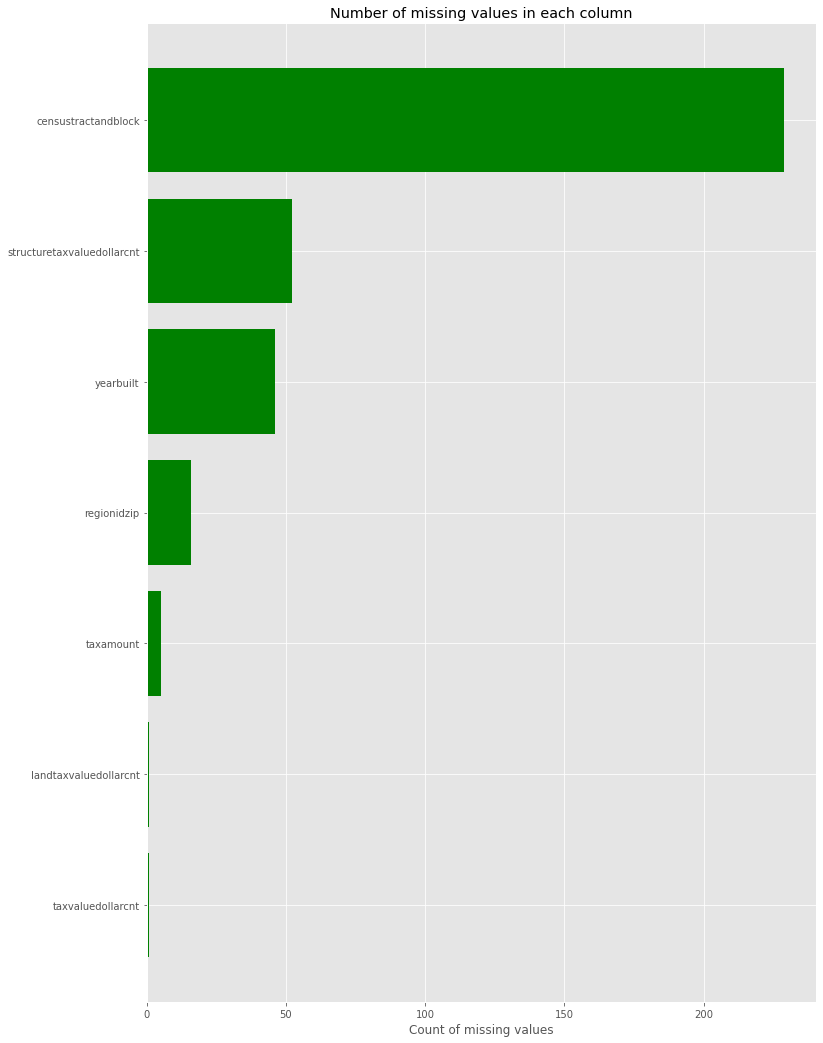

In [26]:
missing_values_barplot(df_train)

The result that we have obtained are satisfying. In order to save some time, we are just going to drop the rows that contain the rest of missing values, since they are in percentages below 1%.

In [27]:
df_train = df_train.dropna(axis=0, how='any')

Let's check one last time the status of our missing data:

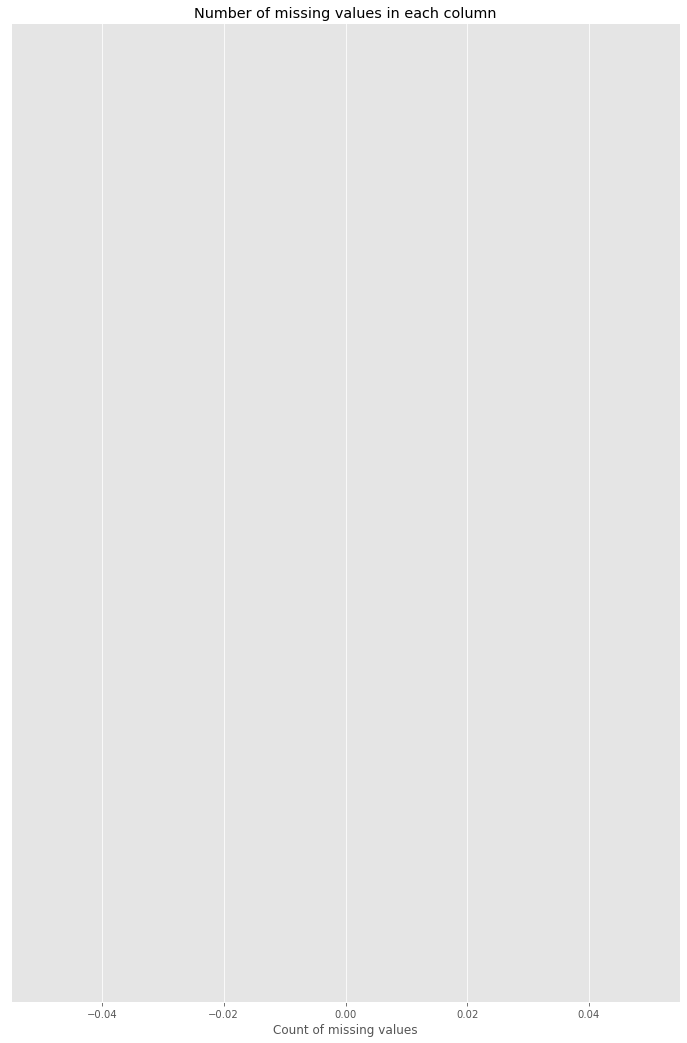

In [28]:
missing_values_barplot(df_train)

Perfect! We can proceed with the next step.

### Step 2.2:  Additional features related to the property

In [29]:
#life of property
df_train['N-life'] = 2022 - df_train['yearbuilt']

#error in calculation of the finished living area of home
df_train['N-LivingAreaError'] = df_train['calculatedfinishedsquarefeet']/df_train['finishedsquarefeet12']

#proportion of living area
df_train['N-LivingAreaProp'] = df_train['calculatedfinishedsquarefeet']/df_train['lotsizesquarefeet']

#Amout of extra space
df_train['N-ExtraSpaceRatio'] = (df_train['lotsizesquarefeet'] - df_train['calculatedfinishedsquarefeet'])/ df_train['calculatedfinishedsquarefeet']

#Total number of rooms
df_train['N-TotalRooms'] = df_train['bathroomcnt'] + df_train['bedroomcnt']

# Number of Extra rooms
df_train['N-ExtraRooms'] = df_train['roomcnt'] - df_train['N-TotalRooms'] 

#### Step 2.2.2:  Additional features based off the tax related variables

In [30]:
#Ratio of tax of property over parcel
df_train['N-ValueRatio'] = df_train['taxvaluedollarcnt']/df_train['taxamount']

#TotalTaxScore
df_train['N-LogTaxScore'] = df_train['taxvaluedollarcnt'] * df_train['taxamount']
df_train['N-LogTaxScore'] = df_train['N-LogTaxScore'].map(lambda b: log10(b))

#### Step 2.2.3: Additional variables which are simplification of some of the other variables

In [31]:
#Indicator whether it has AC or not
df_train['N-ACInd'] = (df_train['airconditioningtypeid']!=5)*1

#Indicator whether it has Heating or not 
df_train['N-HeatInd'] = (df_train['heatingorsystemtypeid']!=13)*1

### Step 2.3 DataType conversions
It's important to convert the data in a format that allows us to achieve a consisistent state of the dataset. What follows is a list of all the data types present in the dataset. 

The following snippet will print the aforementioned list.

We are going to collect the 'object' features for later use.

#### Step 2.3.1 DataType 

In [32]:
type_list = df_train.dtypes.to_list()
objects = []
for i in range(len(list(df_train.columns))):
    print(f"[{df_train.columns[i]}]: {' ' * (35 - len(df_train.columns[i]) - 2)} {type_list[i]}")
    if type_list[i] == object:
        objects.append(df_train.columns[i])

[parcelid]:                           int64
[airconditioningtypeid]:              float64
[bathroomcnt]:                        float64
[bedroomcnt]:                         float64
[buildingqualitytypeid]:              float64
[calculatedbathnbr]:                  float64
[calculatedfinishedsquarefeet]:       float64
[finishedsquarefeet12]:               float64
[fips]:                               float64
[fullbathcnt]:                        float64
[garagecarcnt]:                       float64
[garagetotalsqft]:                    float64
[heatingorsystemtypeid]:              float64
[latitude]:                           float64
[longitude]:                          float64
[lotsizesquarefeet]:                  float64
[poolcnt]:                            float64
[pooltypeid7]:                        float64
[propertycountylandusecode]:          object
[propertylandusetypeid]:              float64
[rawcensustractandblock]:             float64
[regionidcity]:                      

After the discovery of the type of the remaining features, we are going to convert the ones that have 'object' as type.
First of all, let's see who they are:

In [33]:
objects

['propertycountylandusecode', 'transactiondate']

It is important that 'transactiondate' is handled by itself, so we are going to remove it from the list.
Now, we can convert these features' types to more appropriate ones, by using the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) object, provided by sklearn.

In [34]:
def object_encoding(feature):
    lbl = LabelEncoder()
    lbl.fit(list(feature.values))
    return lbl.transform(list(feature.values))

objects = list(set(objects) - set(['transactiondate']))

for col in objects:
    df_train[col] = object_encoding(df_train[col])

#### Step 2.3.2 Transaction Date type conversion
The Date Type cannot be usually read by the classifiers and the predictors. After we have handled this feature, we are going to drop it. We can do it here, since it has no missing values, so it does not need further cleaning.

Since it`s hard to predict which is the best way to manipulate this information, we are going to add some new features that will allow us to have more than one option when it comes to assessing the importance of the features.

What follows is a list of new features that we can derive from the transaction date. Then, we will proceed to implement them.

- `NDaysInCurrentYear`, the number of days from January 1st.

- `DD`, the day of the month.

- `MM`, the month of the year.

The year of the transaction date is not considered because we are using only the 2016 dataset.

By looking at [this article](https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/), it looks like there are a lot more of options available. But, since we are trying to keep this model as simple as possible, we will ignore them.

In [35]:
df_train['DD'] = df_train['transactiondate'].str.replace("-","").astype(int)
df_train['DD'] = df_train['DD'].apply(lambda r: r % 100)
df_train['MM'] = df_train['transactiondate'].str.replace("-","").astype(int)
df_train['MM'] = df_train['MM'].apply(lambda r: int(((r - (r % 100)) / 100) % 100))
df_train['N-DaysInCurrentYear'] = df_train['transactiondate'].apply(lambda r: pd.Period(r).day_of_year)
df_train = df_train.drop(['transactiondate'], axis=1)

### Step 2.4 - Data rescaling
We need to consider that some implementations of predicting models may not handle big numeric data types very well. Our dataset presents some features whose values interval may be too large to handle.


In [36]:
df_train.describe(include='all')

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,N-life,N-LivingAreaError,N-LivingAreaProp,N-ExtraSpaceRatio,N-TotalRooms,N-ExtraRooms,N-ValueRatio,N-LogTaxScore,N-ACInd,N-HeatInd,DD,MM,N-DaysInCurrentYear
count,8.526000e+04,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,8.526000e+04,8.526000e+04,8.526000e+04,85260.000000,85260.000000,85260.000000,85260.000000,8.526000e+04,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,8.526000e+04,8.526000e+04,85260.0,8.526000e+04,85260.000000,8.526000e+04,85260.000000,85260.000000,85260.0,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000
mean,1.300831e+07,3.940464,2.273006,3.003718,5.518313,2.292370,1744.828114,1744.828114,6049.181891,2.202451,0.632196,120.947455,7.051501,3.400606e+07,-1.181975e+08,2.770928e+04,0.208902,-0.610439,16.714075,262.534166,6.049489e+07,33041.929838,2510.354504,313517.152081,96597.046481,1.551009,0.141110,1.003882,1969.648076,1.365323,1.802959e+05,4.577877e+05,2015.0,2.774918e+05,5950.011678,6.049493e+13,0.011847,52.351924,1.0,0.251669,20.615613,5.276724,-3.725715,76.172455,9.148169,0.330624,0.654609,16.351865,5.866444,164.288576
std,2.501356e+06,2.281202,0.942914,1.010668,1.528335,1.025875,910.132596,910.132596,20.842449,0.926120,0.935511,228.323631,5.242937,2.678723e+05,3.651736e+05,1.170653e+05,0.406527,0.792068,18.114525,2.480914,2.068262e+05,45917.853125,810.696899,261495.298980,3619.142402,2.870366,0.351923,0.543855,23.032999,0.393560,2.096894e+05,5.552339e+05,0.0,3.986431e+05,6809.581404,2.068273e+11,0.154299,23.032999,0.0,0.208196,90.184032,1.746947,3.123941,31.379033,0.681431,0.470441,0.475498,8.994995,2.807128,85.608589
min,1.071174e+07,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,6037.000000,0.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,0.000000,-1.000000,0.000000,246.000000,6.037101e+07,0.000000,1286.000000,6952.000000,95982.000000,0.000000,0.000000,1.000000,1885.000000,1.000000,1.000000e+02,1.044000e+03,2015.0,2.780000e+02,49.080000,6.037101e+13,-4.605000,7.000000,1.0,0.000179,-0.913021,0.000000,-23.000000,2.438853,4.824880,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.153918e+07,1.000000,2.000000,2.000000,4.000000,2.000000,1171.000000,1171.000000,6037.000000,2.000000,0.000000,0.000000,2.000000,3.380784e+07,-1.184183e+08,5.503000e+03,0.000000,-1.000000,1.000000,261.000000,6.037401e+07,12447.000000,1286.000000,54300.000000,96208.000000,0.000000,0.000000,1.000000,1954.000000,1.000000,8.159800e+04,1.997625e+05,2015.0,8.159800e+04,2861.877500,6.037401e+13,-0.024300,35.000000,1.0,0.142310,2.209749,4.000000,-6.000000,70.709451,8.756233,0.000000,0.000000,8.000000,4.000000,97.000000
50%,1.259030e+07,5.000000,2.000000,3.000000,5.565407,2.000000,1516.500000,1516.500000,6037.000000,2.000000,0.000000,0.000000,7.000000,3.402349e+07,-1.181640e+08,7.098000e+03,0.000000,-1.000000,8.000000,261.000000,6.037621e+07,25218.000000,3101.000000,273930.000000,96403.000000,0.000000,0.000000,1.000000,1971.000000,1.200000,1.320050e+05,3.434420e+05,2015.0,1.932350e+05,4526.525000,6.037621e+13,0.006000,51.000000,1.0,0.214227,3.667943,5.000000,-4.500000,79.560010,9.181363,0.000000,1.000000,16.000000,6.000000,167.000000
75%,1.425592e+07,5.

The following features are the ones that we identified as problematic. We will start by plotting their distributions with boxplots.

In [37]:
to_rescale = [
'latitude',
'longitude',
'lotsizesquarefeet',
'rawcensustractandblock',
'structuretaxvaluedollarcnt',
'taxvaluedollarcnt',
'landtaxvaluedollarcnt',
'censustractandblock',
'rawcensustractandblock',
'pooltypeid7']

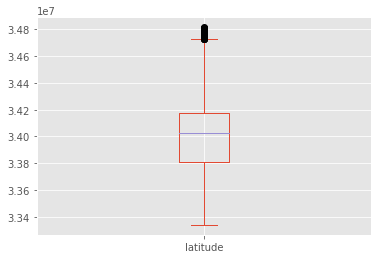

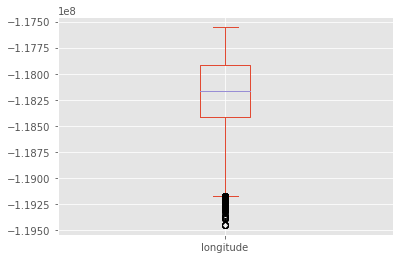

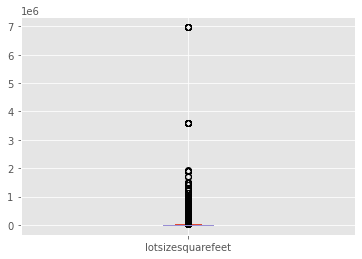

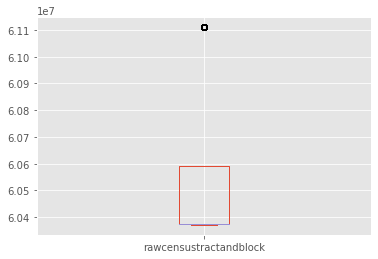

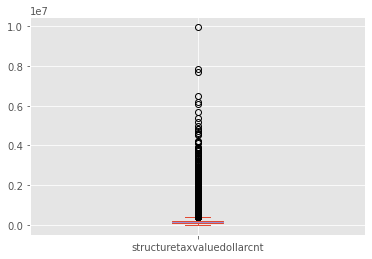

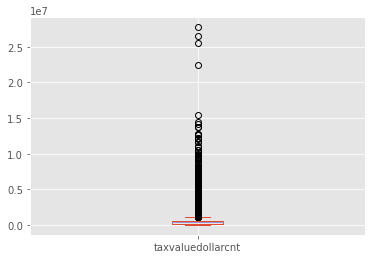

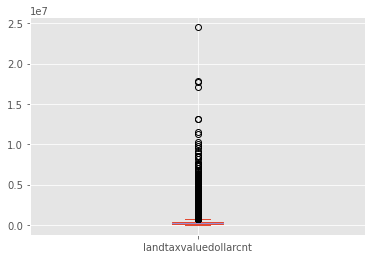

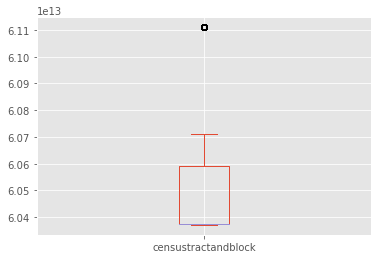

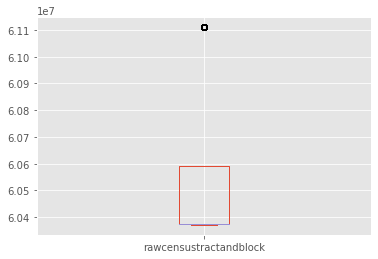

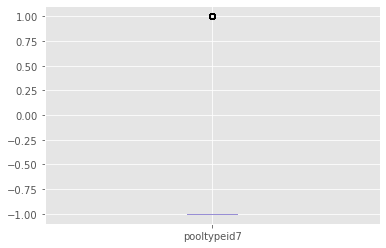

In [38]:
for col in to_rescale:
    df_train.plot.box(column=col)

The more appropriate thing to do is to rescale them, using the MinMax normalization. We will use the [ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) implementation.

The only exception is made for `pooltypeid7`: the values of this feature are -1 and 1. We are just going to convert the -1 values to 0.

In [39]:
df_train['pooltypeid7'] = df_train['pooltypeid7'].replace(to_replace=-1., value=0.)

In [40]:
def MinMaxRescaling(features, min_v=0, max_v=1):
    scaler = MinMaxScaler(feature_range=(min_v, max_v), copy=False) #in place
    scaler.fit(features)
    return scaler.transform(features)

In [41]:
# Rescaling
df_train[to_rescale] = MinMaxRescaling(df_train[to_rescale])

Let's check the status of the dataset before proceeding with the final steps.

In [42]:
df_train.describe(include='all')

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,N-life,N-LivingAreaError,N-LivingAreaProp,N-ExtraSpaceRatio,N-TotalRooms,N-ExtraRooms,N-ValueRatio,N-LogTaxScore,N-ACInd,N-HeatInd,DD,MM,N-DaysInCurrentYear
count,8.526000e+04,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.0,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.0,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000,85260.000000
mean,1.300831e+07,3.940464,2.273006,3.003718,5.518313,2.292370,1744.828114,1744.828114,6049.181891,2.202451,0.632196,120.947455,7.051501,0.451522,0.660546,0.003951,0.208902,0.194781,16.714075,262.534166,0.167615,33041.929838,2510.354504,313517.152081,96597.046481,1.551009,0.141110,1.003882,1969.648076,1.365323,0.018114,0.016460,2015.0,0.011315,5950.011678,0.167662,0.011847,52.351924,1.0,0.251669,20.615613,5.276724,-3.725715,76.172455,9.148169,0.330624,0.654609,16.351865,5.866444,164.288576
std,2.501356e+06,2.281202,0.942914,1.010668,1.528335,1.025875,910.132596,910.132596,20.842449,0.926120,0.935511,228.323631,5.242937,0.181398,0.192913,0.016794,0.406527,0.396034,18.114525,2.480914,0.279843,45917.853125,810.696899,261495.298980,3619.142402,2.870366,0.351923,0.543855,23.032999,0.393560,0.021079,0.020009,0.0,0.016271,6809.581404,0.279844,0.154299,23.032999,0.0,0.208196,90.184032,1.746947,3.123941,31.379033,0.681431,0.470441,0.475498,8.994995,2.807128,85.608589
min,1.071174e+07,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,6037.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,246.000000,0.000000,0.000000,1286.000000,6952.000000,95982.000000,0.000000,0.000000,1.000000,1885.000000,1.000000,0.000000,0.000000,2015.0,0.000000,49.080000,0.000000,-4.605000,7.000000,1.0,0.000179,-0.913021,0.000000,-23.000000,2.438853,4.824880,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.153918e+07,1.000000,2.000000,2.000000,4.000000,2.000000,1171.000000,1171.000000,6037.000000,2.000000,0.000000,0.000000,2.000000,0.317289,0.543914,0.000765,0.000000,0.000000,1.000000,261.000000,0.004058,12447.000000,1286.000000,54300.000000,96208.000000,0.000000,0.000000,1.000000,1954.000000,1.000000,0.008192,0.007161,2015.0,0.003319,2861.877500,0.004059,-0.024300,35.000000,1.0,0.142310,2.209749,4.000000,-6.000000,70.709451,8.756233,0.000000,0.000000,8.000000,4.000000,97.000000
50%,1.259030e+07,5.000000,2.000000,3.000000,5.565407,2.000000,1516.500000,1516.500000,6037.000000,2.000000,0.000000,0.000000,7.000000,0.463325,0.678238,0.000994,0.000000,0.000000,8.000000,261.000000,0.007038,25218.000000,3101.000000,273930.000000,96403.000000,0.000000,0.000000,1.000000,1971.000000,1.200000,0.013259,0.012339,2015.0,0.007876,4526.525000,0.007038,0.006000,51.000000,1.0,0.214227,3.667943,5.000000,-4.500000,79.560010,9.181363,0.000000,1.000000,16.000000,6.000000,167.000000
75%,1.425592e+07,5.000000,3.000000,4.000000,7.000000,3.000000,2055.000000,2055.000000,6059.000000,3.000000,2.000000,0.000000,13.000000,0.566465,0.810308,0.001611,0.000000,0.000000,38.0000

## Step 3: Development and Modeling
This step involves presenting
the dataset to the target audience in the form of graphs, summary tables, maps,
and diagrams.

### Step 3.1: Assessing feature importance
Let's use XGBoost to assess the importance of our features.

We need to rescale some values before training our model, because of some errors raised by the presence of large data types.

We are going to use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from Sklearn to achieve some normalization on our data.

In [43]:
train_y = df_train['logerror'].values
df_assess = df_train.drop(['parcelid', 'logerror', 'propertycountylandusecode'], axis=1)
feat_names = df_assess.columns.values

In [44]:
def rescale_data_XGBoost(x_train, x_names):
    scaler = StandardScaler() 
    x_train = x_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    return pd.DataFrame(scaler.fit_transform(x_train),columns=x_names)

[13:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




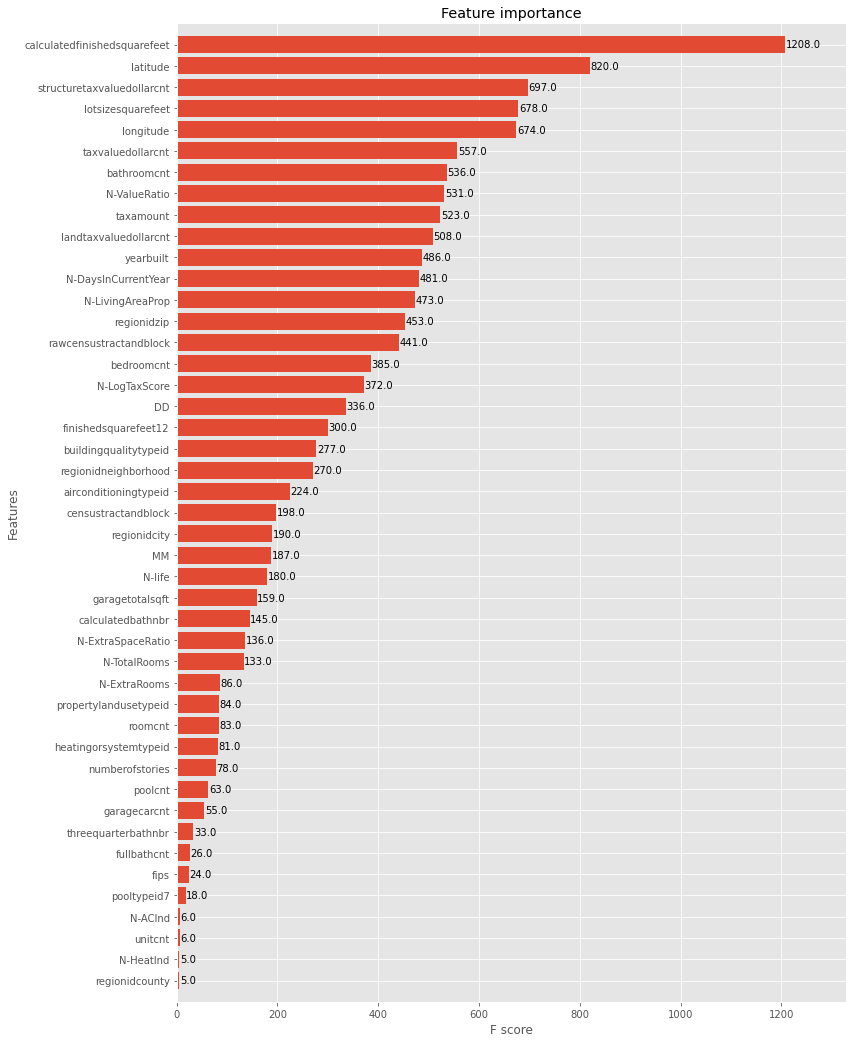

In [45]:
df_assess = rescale_data_XGBoost(df_assess, feat_names)

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_assess, train_y, feature_names=df_assess.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Step 3.2 Top Features Selection

Basing on the results of the XGBoost algorithm, it looks like some feature have very low importance.
It is crucial that we save some space, so we are going to drop the feature whose F-score is below 600. This value was decided after a process of trial and error.

In [46]:
features_imp = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=True)
features_imp = features_imp.loc[features_imp['importance'] < 600]
df_train.drop(list(features_imp['feature']), axis=1, inplace=True)

The evaluation of the features' importance showed that, even if some custom features are in the top part of the ranking, most of the feature added did not produce significant variations.

It was necessary to higher the value of the F-score in order to prevent the overfitting of the models. Even with the current value, the second algorithm that was tested overfitted, leading to no significant conclusions.

## Step 4: Cross Validation & Export
### Cross Validation & Overfitting
The threat of overfitting is always behind the corner. 

Overfitting is the low predictive power of the model, caused by the use of the same dataset for the training phase and the testing phase. Since the goal of the model is to "adapt" to the data on which it trains on, testing its accuracy on the same dataset would lead to some unaccurate results.

For this reason, we adopted the cross validation, which is a technique that tries to prevent this phenomenon. 

We chose to split the dataset using the k-fold algorithm, by using the library provided by [Scikitlearn](https://scikit-learn.org/stable/modules/cross_validation.html).

This method consist in splitting the dataset in k groups (the "folds") and keeping one out as the testing set. This procedure is repeated for each one of the folds, in order to minimize the chances of overfitting. The value we chose for k is 4, because the tests we conducted previously took a very long time.

In [47]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

df_train_folded16, df_test_folded16 = [], []

for train_index, test_index in kf.split(df_train):
    df_train_folded16.append(df_train.iloc[train_index])
    df_test_folded16.append(df_train.iloc[test_index])

### Exporting the cleaned dataset

The following snippet will export the cleaned dataset in a series of file containing the testing and training dataset.



In [48]:
#2016 dataset
i = 0
for ds in df_train_folded16:
  i += 1
  ds.to_csv(f"Data/train_dataset_2016_{i}.csv")

i = 0
for ds in df_test_folded16:
  i += 1
  ds.to_csv(f"Data/test_dataset_2016_{i}.csv")


##### Credits
Credits go to: 
[Simple Exploration Notebook](https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-zillow-prize)
[Zillow analysis with EDA🏠](https://www.kaggle.com/code/hyewon328/zillow-analysis-with-eda)
[Zillow EDA On Missing Values & Multicollinearity](https://www.kaggle.com/code/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity)
[Creating Additional Features](https://www.kaggle.com/code/nikunjm88/creating-additional-features)
[Simple EDA Geo Data & Time Series](https://www.kaggle.com/code/kueipo/simple-eda-geo-data-time-series)
[Carefully dealing with missing values](https://www.kaggle.com/code/nikunjm88/carefully-dealing-with-missing-values)